In [31]:
from hipecta.data import ctaTelescope2Matrix
from hipecta import core
import numpy as np
import h5py
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import hipecta.plots as plots
from torchvision import transforms, utils

In [3]:
def squeeze_data(l):
    """
    Squeeze an array or a list of length 1
    Parameters
    ----------
    l: np.ndarray or list

    Returns
    -------
    variable
    """
    while isinstance(l,(np.ndarray,list)):
        if len(l) == 1:
            l = l[0]
        else:
            break

    return l

In [4]:
class LSTCamDataset(Dataset):
    """LST camera simulation dataset."""
    
    def __init__(self, hdf5_file, transform=None):
        """
        Parameters
        ----------
            hdf5_file (string): path to hdf5 file containing the data
            transform (callable, optional): Optional transform to be applied on a sample
            energy_band (tuple, optional): Optional filter applied on energy of the data source
        """
        self.hdf5_file = hdf5_file
        self.transform = transform
        
    def __len__(self):
        return len(self.hdf5_file['/Cameras/DRAGON/showerId'])
                
    def __getitem__(self, idx):
        image = self.hdf5_file['/Cameras/DRAGON/images'][idx]
        shower_id = self.hdf5_file['/Cameras/DRAGON/showerId'][idx]
        event_id = self.hdf5_file['/Cameras/DRAGON/eventId'][idx]
        idx_showerSimu = squeeze_data(list(np.where(np.array(self.hdf5_file['/showerSimu/showerId']) == shower_id)))
        energy = self.hdf5_file['/showerSimu/energy'][idx_showerSimu]
        altitude = self.hdf5_file['/showerSimu/altitude'][idx_showerSimu]
        azimuth = self.hdf5_file['/showerSimu/azimuth'][idx_showerSimu]
        xCore = self.hdf5_file['/eventSimu/xCore'][(np.array(self.hdf5_file['/eventSimu/eventId']) == event_id) & 
                                      (np.array(self.hdf5_file['/eventSimu/showerId']) == shower_id)]
        yCore = self.hdf5_file['/eventSimu/yCore'][(np.array(self.hdf5_file['/eventSimu/eventId']) == event_id) & 
                                      (np.array(self.hdf5_file['/eventSimu/showerId']) == shower_id)]
        labels = np.array([energy, altitude, azimuth, xCore, yCore])
        sample = {'image': image, 'labels': labels}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [25]:
class TelescopeToSquareMatrix(object):
    """Convert telescope image of vector shape to square matrix.
    
    Args:
        injTable (array of float32): injunction table
        nbRow (int): number of rows of the output matrix
        nbCol (int): number of cols of the output matrix
    
    """
    
    
    def __init__(self, injTable, nbRow, nbCol):
        assert isinstance(injTable, np.ndarray)
        assert isinstance(nbRow, np.int64)
        assert isinstance(nbCol, np.int64)
        self.injTable = injTable
        self.nbRow = nbRow
        self.nbCol = nbCol
        
    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
        
        mat = np.zeros((self.nbRow, self.nbCol))
        mat = ctaTelescope2Matrix.telescope2matrix(mat, image, self.injTable)
        
        return {'image': mat, 'labels': labels}

In [6]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']

        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(labels)}

In [33]:
test_file = '/home/jacquemont/projets_CTA/gamma0.hdf5'
f = h5py.File(test_file, 'r')
injTable = np.array(f['/Cameras/DRAGON/injTable'])
print(type(injTable))
nbRow = f['/Cameras/DRAGON'].attrs['nbRow']
print(type(nbRow))
nbCol = f['/Cameras/DRAGON'].attrs['nbCol']
test_dataset = LSTCamDataset(hdf5_file=f,
                             transform=transforms.Compose([
                                 TelescopeToSquareMatrix(injTable, nbRow, nbCol),
                                 ToTensor()
                             ]))

<class 'numpy.ndarray'>
<class 'numpy.int64'>


In [8]:
len(test_dataset)

10137

588503
5885


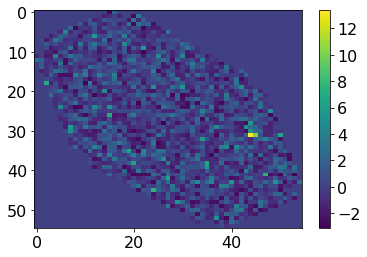

In [35]:
sample = test_dataset[300]
plots.plotmatrix(sample['image'].numpy())

In [38]:
f.close()